## Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import operator
import math
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit, njit
import cupy as cp

### Reading Data
Delete ['Remove']

In [2]:
# Read Data
# Select part to show, because the dataset is too large and cost to much time to have the result
# Will upload result from whole dataset later
during = pd.read_csv('D:/Python/GA/during_comments_clean.csv', nrows = 10000)
post = pd.read_csv('D:/Python/GA/post_comments_clean.csv', nrows = 10000)
pre = pd.read_csv('D:/Python/GA/pre_comments_clean.csv', nrows = 10000)

In [3]:
# There are a lot of ['Remove'] in dataset. 
# They are posts that content has been deleted, so we remove them here.
def remove(dataframe, feature = 'body'):
    df = dataframe[dataframe[feature] != "['remove']"]
    df.reset_index(inplace=True)
    df.drop(['index', 'Unnamed: 0'], axis=1, inplace = True)
    
    return df

In [4]:
# Apply to three stages
during = remove(during)
post = remove(post)
pre = remove(pre)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1048\2266149135.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['index', 'Unnamed: 0'], axis=1, inplace = True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1048\2266149135.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['index', 'Unnamed: 0'], axis=1, inplace = True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1048\2266149135.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [5]:
post

,author_fullname,body,created_utc,distinguished,id,is_submitter,link_id,parent_id,score
0,t2_aikpi,"['🚢', '🌙']",2021-02-09 04:59:58,NaN,gmo07vb,False,t3_lflpoz,t1_gmnylp2,1
1,t2_bn79u8d,"['say', 'sell', 'realize', 'loss', 'tax', 'cre...",2021-02-09 04:59:56,NaN,gmo07s8,False,t3_lflzy4,t1_gmn8lgw,1
2,t2_4d4r9iby,"['spy', '390p', '2/10', 'spy', '392p', '2/10',...",2021-02-09 04:59:55,NaN,gmo07px,False,t3_lflpoz,t3_lflpoz,3
3,t2_6fb5ka0x,"['lol', 'melvin', 'bot', 'factory']",2021-02-09 04:59:54,NaN,gmo07ox,False,t3_lf9hv1,t1_gmnrb2s,1
4,t2_gmtwa,"['put', 'fell', 'burn', 'ring', '🔥', 'go', '🔥'...",2021-02-09 04:59:49,NaN,gmo07ee,False,t3_lflpoz,t3_lflpoz,6
...,...,...,...,...,...,...,...,...,...
7311,t2_ic7o208,"['everyone', 'talk', 'wym']",2021-02-09 03:07:36,NaN,gmnoggc,False,t3_lflpoz,t1_gmnnhlr,1
7312,t2_7hc2w,"['would', 'sorry', 'owe', 'u', 'fuck', 'nice',...",2021-02-09 03:07:36,NaN,gmnogg4,False,t3_lfm36e,t3_lfm36e,1
7313,t2_2ai16a90,"['faith', 'brother', 'even', 'value', 'go', 't...",2021-02-09 03:07:35,NaN,gmnogfd,False,t3_lflpoz,t1_gmnnzoq,5
7314,t2_cxlwn,"['good', 'bot']",2021-02-09 03:07:35,NaN,gmnogf7,False,t3_lf9rdy,t1_gmnntrf,1


In [6]:
# Count word frequency
def count_word_frequency(words):
    w_frequency = dict()
    for word in tqdm(words, desc = 'TF Counting Progress: '):
        if word not in w_frequency.keys():
            w_frequency[word] = words.count(word)
    sorted_d = dict(sorted(w_frequency.items(), key=operator.itemgetter(1),reverse=True))
    return sorted_d

In [7]:
def total_terms(sentences):
    words = []
    
    # Apply Function to count Terms Frequencies
    for i in sentences:
        words+=i.split()
    tf = count_word_frequency(words)
    idfcount = dict()
    
    # Count IDF
    for row in tqdm(sentences, desc = 'IDF Counting Progress: '):
        temp = []
        for w in row.split(' '):
            if w not in temp:
                temp.append(w)
                if w in idfcount:
                    idfcount[w] += 1
                else:
                    idfcount[w] = 1

    sortedtf = dict(sorted(tf.items(), key=operator.itemgetter(1),reverse=True))
    sortedidf = dict(sorted(idfcount.items(), key=operator.itemgetter(1),reverse=True))

    idfValues = dict()
    
    # Calculate IDF Values
    for key in tqdm(sortedtf.keys(), desc = 'IDF Value Calculating Progress: '):
        idfValues[key] = math.log10(len(sentences)/idfcount[key])
    
    # Calculate TF-IDF Values
    tfidfValues = dict()
    for key in tqdm(sortedtf.keys(), desc = 'TF-IDF Value Progress: '):
        tfidfValues[key] = idfValues[key] * tf[key]
    sortedtfidf = dict(sorted(tfidfValues.items(), key=operator.itemgetter(1),reverse=True))

    return sortedtf, idfValues, sortedtfidf

In [8]:
# Show Table of TF, IDF, TF-IDF
def show_num_terms(dicts, sortby, complete = False):
    columnnames = ['TF','IDF','TF-IDF']
    summary = []
    for key in dicts[0].keys():
        summary.append([dicts[0][key], dicts[1][key], dicts[2][key]])
    df = pd.DataFrame(summary,index = dicts[0].keys(), columns = columnnames)
    if(complete):
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(df.sort_values(by=columnnames[sortby], ascending=False))
    else:
        display(df.sort_values(by=columnnames[sortby], ascending=False))

In [9]:
# Create WordCloud
def show_wordcloud(sentences, save=False, img_name=None):
  wordcloud = WordCloud(
    background_color = 'white',
    max_words = 1000,
    relative_scaling = 1,
    scale = 3,
    random_state=1,
    collocations=False
  ).generate_from_frequencies(sentences)
  fig = plt.figure(1, figsize=(12, 12))
  plt.axis('off')
  plt.imshow(wordcloud)
  if save: plt.savefig(img_name)
  plt.show()

In [10]:
# During stage
d_tff, d_idff, d_tfidf = total_terms(during.body)

TF-IDF Value Progress: 100%|██████████| 10624/10624 [00:00<00:00, 2125055.35it/s]


In [12]:
# Post Stage
post_tff, post_idff, post_tfidf = total_terms(post.body)

TF-IDF Value Progress: 100%|██████████| 13036/13036 [00:00<00:00, 2607388.98it/s]


In [13]:
# Pre Stage
pre_tff, pre_idff, pre_tfidf = total_terms(pre.body)

TF-IDF Value Progress: 100%|██████████| 14355/14355 [00:00<00:00, 1794291.15it/s]


In [14]:
# TF-IDF During Stage
show_num_terms([d_tff,d_idff,d_tfidf],0)

,TF,IDF,TF-IDF
"'go',",500,1.117928,558.963867
"'get',",448,1.142634,511.899856
"'buy',",440,1.193125,524.974823
"'gme',",414,1.201534,497.435257
"'like',",405,1.200323,486.130821
...,...,...,...
"'frame',",1,3.755417,3.755417
"'manner',",1,3.755417,3.755417
"['smoke',",1,3.755417,3.755417
"'purification',",1,3.755417,3.755417


In [16]:
# TF-IDF Post Stage
show_num_terms([post_tff, post_idff, post_tfidf],0)

,TF,IDF,TF-IDF
"'go',",757,1.059453,802.005935
"'get',",671,1.095636,735.171485
"'like',",553,1.168792,646.341987
"'buy',",519,1.219835,633.094421
"'make',",458,1.266579,580.092958
...,...,...,...
'//old.reddit.com/r/wallstreetbets/comments/4ecrxw/discussion_what_were_your_moves_today_april_11/d1z0n8p/'],1,3.864274,3.864274
"'simulator',",1,3.864274,3.864274
['shortsqueeze.com'],1,3.864274,3.864274
'moment'],1,3.864274,3.864274


In [17]:
# TF-IDF Pre Stage
show_num_terms([pre_tff, pre_idff, pre_tfidf],0)

,TF,IDF,TF-IDF
"'go',",1139,1.009828,1150.194043
"'gme',",1053,1.040621,1095.774347
"'buy',",959,1.085770,1041.253344
"'get',",923,1.082463,999.113426
"'share',",886,1.137407,1007.742415
...,...,...,...
'mu'],1,3.980640,3.980640
'🦽🐸'],1,3.980640,3.980640
"'waddup',",1,3.980640,3.980640
'crsr'],1,3.980640,3.980640


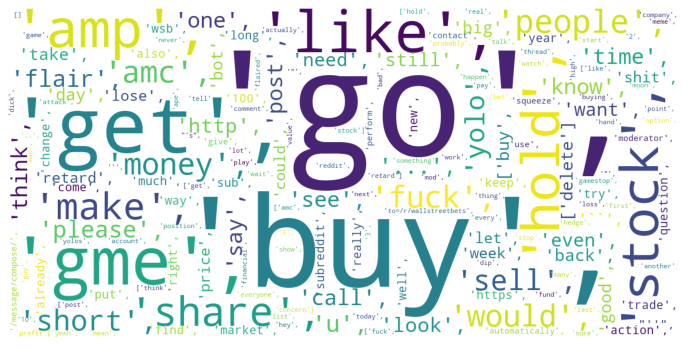

In [18]:
# WordCloud During Stage
show_wordcloud(d_tfidf)

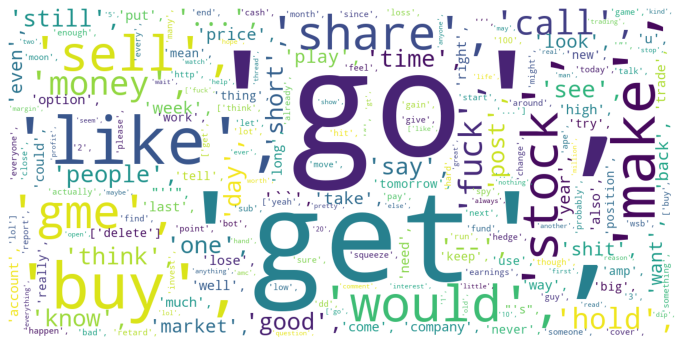

In [19]:
# WordCloud Post Stage
show_wordcloud(post_tfidf)

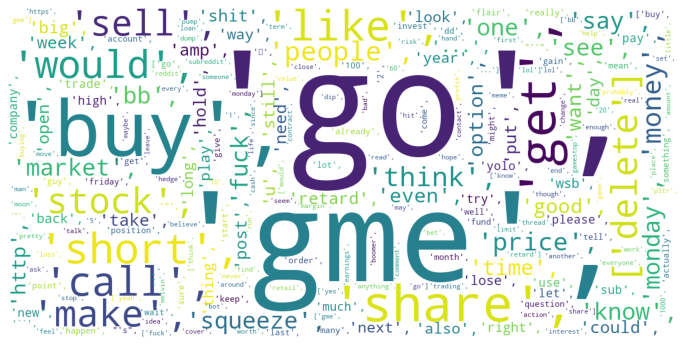

In [20]:
# WordCloud Pre Stage
show_wordcloud(pre_tfidf)